## Solve a heat equation for variable diffusion D
This script includes D as an input to the network, such that the trained network solves the heat equation for a whole range of diffusion coefficients

In [1]:
import torch
import numpy as np
import pytorch_lightning as pl
from timeit import default_timer as timer

from torchphysics.problem import Variable
from torchphysics.setting import Setting
from torchphysics.problem.domain import (Rectangle,
                                           Interval)
from torchphysics.problem.condition import (DirichletCondition,
                                              DiffEqCondition,
                                              DataCondition)
from torchphysics.models.fcn import SimpleFCN
from torchphysics import PINNModule
from torchphysics.utils import laplacian, grad
from torchphysics.utils.fdm import FDM, create_validation_data
from torchphysics.utils.plot import Plotter
from torchphysics.utils.evaluation import (get_min_max_inside,
                                             get_min_max_boundary)
from torchphysics.setting import Setting

os.environ["CUDA_VISIBLE_DEVICES"] = "2" # select GPUs to use

#pl.seed_everything(43) # set a global seed
torch.cuda.is_available()


/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


True

We define some parameters that describe the setting:

In [2]:
w, h = 40, 40
t0, tend = 0, 2
temp_hot = 10
D_low, D_up = 5, 25  # set here the interval boundary for D

We define the independent variables of the PDE, which will later determine the inputs to the NN. Every variable has a domain and can have one or more boundary conditions.

In [3]:
x = Variable(name='x',
             order=2,
             domain=Rectangle(corner_dl=[0, 0],
                              corner_dr=[w, 0],
                              corner_tl=[0, h]),
             train_conditions={},
             val_conditions={})
t = Variable(name='t',
             order=1,
             domain=Interval(low_bound=0,
                             up_bound=tend),
             train_conditions={},
             val_conditions={})
D = Variable(name='D',
             order=0,
             domain=Interval(low_bound=D_low,
                             up_bound=D_up),
             train_conditions={},
             val_conditions={})

Now we add the wanted boundary conditions to x and t and define the norm that will be used in all training conditions. Every condition has a name string, a torch Module as a given norm (L2 in this case), a weight used during optimization, and the option to plot the training data points to tensorboard during training.

In [4]:
norm = torch.nn.MSELoss()

# Dirichlet functions should act on the given dictionarys of numpy arrays:
def x_dirichlet_fun(x):
    return 0
# a DirichtletCondition generates data points at which the dirichlet_fun is evaluated
# and the Dirichlet condition is enforced. There are different strategys for sampling,
# 'random' and 'grid' are always implemented.

# The flag 'whole_batch=False' can be used to pass a point-wise defined dirichlet_fun.
# This avoids the batch-wise notion, which can make function definitions complicated
x.add_train_condition(DirichletCondition(dirichlet_fun=x_dirichlet_fun,
                                         whole_batch=False,
                                         name='dirichlet',
                                         sampling_strategy='random',
                                         boundary_sampling_strategy='random',
                                         norm=norm,
                                         weight=1.0,
                                         dataset_size=500,
                                         data_plot_variables=('x','t')))

# the same can be done to achieve an initial condition for the time axis:
def t_dirichlet_fun(x):
    return temp_hot*np.sin(np.pi/w*x[0])*np.sin(np.pi/h*x[1])
# to get only initial (and not end-) values, we can set boundary_sampling_strategy to sample
# only one bound of the interval
t.add_train_condition(DirichletCondition(dirichlet_fun=t_dirichlet_fun,
                                         name='dirichlet',
                                         whole_batch=False,
                                         norm=norm,
                                         dataset_size=500,
                                         boundary_sampling_strategy='lower_bound_only',
                                         data_plot_variables=('x','t')))


Using the same notation, we can also define a PDE-condition to the inner of the domain.

In [5]:
# a pde function handle takes the output and the input (as a dict again) of the network. We can use
# functions like 'laplacian' from the utils part to compute common differential operators.

# similar to the boundary conditions, the names of the local variables should match the global
# variables or parameters.
# But while 'data_fun's use np arrays and can be implemented pointwise, functions that are called
# in every iteration of the training (like PDEs) work exclusively with batches of torch data
def pde(u, x, t, D):
    return grad(u, t) - D*laplacian(u, x)

# a DiffEqCondition works similar to the boundary condiitions
train_cond = DiffEqCondition(pde=pde,
                             name='pde',
                             norm=norm,
                             sampling_strategy='random',
                             weight=1.0,
                             dataset_size=5000,
                             data_plot_variables=('x','t'))

For comparison during validation, we solve the problem for some D using a simple FDM scheme:

In [6]:
domain_dic = {'x': [[0, w], [0, h]]}
dx, dy = 0.5, 0.5
step_width_dict = {'x': [dx, dy]}
time_interval = [t0, tend]

D_list = [5, 10, 15, 20, 25]
# ^Here you can add many different values for D, e.g [18.8,2.5,20,....]
# The FDM-Methode will compute solutions for all D.
# For too many D this will become really memory expensive, since
# the FDM uses a forward euler!
fdm_start = timer()
domain, time, u = FDM(domain_dic, step_width_dict, time_interval,
                      D_list, t_dirichlet_fun)
fdm_end = timer()
print('Time for FDM-Solution:', fdm_end-fdm_start)
data_x, data_u = create_validation_data(domain, time, u, D_list, D_is_input=True)
# True: if D is input of the model

Time for FDM-Solution: 1.7920874431729317


Using the FDM solution, we can also define a DataCondition that measures the distance between the computed solution and the FDM solution (w.r.t. max-norm) during validation.

In [7]:
class InfNorm(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_a, input_b):
        return torch.max(torch.abs(input_a-input_b))

max_norm = InfNorm()

val_cond = DataCondition(data_x=data_x,
                         data_u=data_u,
                         name='validation',
                         norm=norm)

The variables (with their boundary conditions) as well as the conditions for the inner part of the domain are collected in a Setting:

In [8]:
setup = Setting(variables=(x, t, D),
                train_conditions={'pde': train_cond},
                val_conditions={'validation': val_cond},
                n_iterations=500)

To solve the problem defined by setting using a PINN, we define a solver. A plotter can help us to visualize intermediate results in the tensorboard.

In [9]:
plotter = Plotter(plot_variables=setup.variables['x'],
                  points=400,
                  dic_for_other_variables={'t': 1.0, 'D': 15.0},
                  all_variables=setup.variables,
                  log_interval=1)

# the solver takes a neural network model and the created setting
# and defines which optimizer is used in training


solver = PINNModule(model=SimpleFCN(input_dim=4,
                                    depth=4,
                                    width=20),
                    optimizer=torch.optim.Adam,
                    lr=1e-3,
                    #log_plotter=plotter
                    )

Finally, we define a lightning trainer and train the model. A lightning trainer has many options, some of them are used here:

In [10]:
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=2,
                     log_every_n_steps=15,
                     max_epochs=15,
                     logger=False,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.8 K 
------------------------------------
1.8 K     Trainable params
0         Non-trainable params
1.8 K     Total params
0.007     Total estimated model params size (MB)
Epoch 1: 100%|█████████▉| 500/501 [00:13<00:00, 36.59it/s, loss=0.586]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████▉| 500/501 [00:13<00:00, 36.36it/s, loss=0.287]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████▉| 500/501 [00:13<00:00, 35.96it/s, loss=0.144]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|█████████▉| 500/501 [00:13<00:00, 36.26it/s, loss=0.112]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|█████████▉| 500/501 [00:13<00:00, 36.63it/s, loss=0.0894]
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|█████████▉| 500/501 [00:13<00:00, 36.41it/s, loss=0.0746]
Validating: 0it [00:00, ?it/s]
Epo

We can also measure the time needed to evaluate the model (on gpu or cpu) and plot the obtained approximation of the solution.

In [11]:
from torchphysics.problem.datacreator import InnerDataCreator
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
dc = InnerDataCreator(variables={'x': x, 't': t, 'D': D},
                      dataset_size=[2000, 400, 1], 
                      # Here we use different number of points for each variable
                      # x has 100 points, t = 20 and D only 1 (constant) value.
                      # The number of total points are all different combinations:
                      # -> 2000 different points
                      sampling_strategy='grid')
input_dic = dc.get_data() # create the data
# Change the D (if you want):
input_dic['D'] = 10 * np.ones((len(input_dic['D']), 1))
# cast everything to tensors:
for name in input_dic:
    input_dic[name] = torch.FloatTensor(input_dic[name]).to(device)
# Evaluate
solver = solver.to(device)
start = time.time()
pred = solver.forward(input_dic) 
end = time.time()
print('Time to evaluate model:', end - start)
print('For:', len(input_dic['x']), 'different points')

cuda
Time to evaluate model: 0.0027344226837158203
For: 800000 different points


-- Start evaluation of minimum and maximum --
Time to evaluate model: 0.054262399673461914
For the variables: {'t': 3, 'D': 20}
Found inside:
Max: 5.0183344
Min: -0.16267475
-- Start evaluation of minimum and maximum at the boundary --
Time to evaluate model: 0.0006554126739501953
For the variables: {'t': 3, 'D': 20}
Found at the boundary:
Max: 0.45721635
Min: -0.28116825


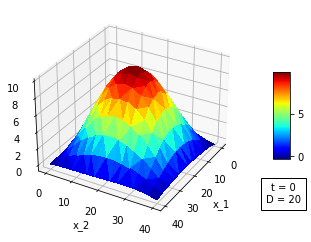

In [12]:
from torchphysics.utils.plot import _plot
solver = solver.to('cpu')
fig = _plot(model=solver.model, plot_variables=x, points=200, angle=[30, 30], 
            dic_for_other_variables={'t' : 0, 'D' : 20})
min_inside, max_inside = get_min_max_inside(solver.model, domain_variable=x, 
                                            resolution=1600, 
                                            dic_for_other_variables={'t': 3, 'D':20})
min_bound, max_bound = get_min_max_boundary(solver.model, boundary_variable=x, 
                                            resolution=1000, 
                                            dic_for_other_variables={'t': 3, 'D': 20})